In [1]:
# Import Distributions to generate random numbers W matrix of the RBM
using Distributions
using MNIST
using BenchmarkTools
using PyPlot
using Combinatorics
using ImageView

LoadError: LoadError: LoadError: LoadError: UndefVarError: LambdaInfo not defined
while loading /home/david/.julia/v0.6/Tk/src/core.jl, in expression starting on line 116
while loading /home/david/.julia/v0.6/Tk/src/Tk.jl, in expression starting on line 39
while loading /home/david/.julia/v0.6/ImageView/src/ImageView.jl, in expression starting on line 10

In [7]:
X_train, y_train = MNIST.traindata()
X_test, y_test = MNIST.testdata()

T = Float32
X_train = Array{T}( (X_train - minimum(X_train))/(maximum(X_train) - minimum(X_train)) )
y_train = Array{T}(y_train)
X_test = Array{T}(X_test - minimum(X_test))/(maximum(X_test) - minimum(X_test)) 
y_test = Array{T}(y_test);

In [126]:
function sigmoid(x::Float32)
    return 1/(1 + exp(-x))
end

type RBM{T <: Real}
    n_vis::Int
    n_hid::Int
    W::Matrix{T}         
    vis_bias::Vector{T}     
    hid_bias::Vector{T}   
    trained::Bool
end

function initialize_RBM(n_vis, n_hid, sigma, T)
    
    return RBM{T}( n_vis,                                 # num visible units 
                   n_hid,                                 # num hidden unnits
                   rand(Normal(0,sigma), n_hid, n_vis),  # weight matrix
                   zeros(n_vis),                          # visible vector  
                   zeros(n_hid),                          # Hidden vector
                   false)                                 # trained
end

function Base.show{T}(io::IO, rbm::RBM{T})
    n_vis = size(rbm.vis_bias, 1)
    n_hid = size(rbm.hid_bias, 1)
    trained = rbm.trained
    print(io, "RBM{$T}(n_vis=$n_vis, n_hid=$n_hid, trained=$trained)")
end

function generate_M(W, n_columns)

    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns))   

    print("\ncostat: ",costat,
          " \nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    M = zeros(costat * n_rows, costat * n_columns)
    
    n_im = 1
    for r in 1:costat:size(M)[1]
        for c in 1:costat:size(M)[2]
            M[r:r+costat-1, c:c+costat-1] = reshape(W[n_im,:],costat,costat)
            n_im +=1
        end
    end
    return M
end


function fit!(rbm, X, batch_size::Integer,  n_epochs::Integer, K::Integer, lr::Real,T, shuffle_data)
        
    n_samples = size(X)[2]
    indicies = [x:min(x + batch_size-1, n_samples) for x in 1:batch_size:n_samples]
    sample_perm = Vector(1:n_samples)
    
    mb = 1
    rec_errors = Vector{Float32}([])
    
    for epoch in 1:n_epochs
        rec_error = Float32(0.)
        if shuffle_data==true
            shuffle!(sample_perm)
            X = X[:,sample_perm]
        end
        
        for minibatch_ind in indicies
            rec_error += partial_fit!(rbm, X[:, minibatch_ind], K, lr,T)
        end
        
        push!(rec_errors, rec_error/length(indicies))

    end
    rbm.trained = true
    return rec_errors
end


function partial_fit!(rbm, Xbatch, K::Integer, lr::Real, T)
    
    Xneg = Xbatch
    batch_size = size(Xbatch)[2]
    
    local Hneg::Array{T} = zeros(rbm.n_hid, batch_size)
    local Xneg::Array{T} = zeros(rbm.n_vis, batch_size)
    local Ehp::Array{T} = zeros(rbm.n_hid, batch_size)
    local Ehn::Array{T} = zeros(rbm.n_hid, batch_size)
    
    for k in 1:K
        Hneg .= sigmoid.(rbm.W * Xneg .+ rbm.hid_bias) .> rand()
        Xneg .= sigmoid.(rbm.W' * Hneg  .+ rbm.vis_bias) .> rand()
    end
       
    Ehp .= sigmoid.(rbm.W * Xbatch .+ rbm.hid_bias)
    Ehn .= sigmoid.(rbm.W * Xneg .+ rbm.hid_bias)
    
    rbm.W .+= lr.*( Ehp * Xbatch' .-  Ehn *  Xneg') ./ batch_size;
    rbm.vis_bias .+= sum(lr .* (Xbatch .- Xneg), 2)[:]./ batch_size;
    rbm.hid_bias .+= sum(lr .* (Ehp .- Ehn), 2)[:] ./ batch_size;

    return sqrt(sum((Xbatch.-Xneg).^2))

end


partial_fit! (generic function with 1 method)

In [138]:
rbm = initialize_RBM(784, 100, 0.01, Float32)

RBM{Float32}(n_vis=784, n_hid=100, trained=false)

In [139]:
X_batch = X_train[:, 1:25]
partial_fit!(rbm,X_batch, 1, 0.01, T)

44.0383f0

In [142]:
n_epochs = 40
batch_size = 500
K = 1
lr = 0.01

rec_errors = fit!(rbm, X_train, batch_size,  n_epochs, K, lr, T, false)

40-element Array{Float32,1}:
 258.678
 253.191
 257.89 
 245.765
 251.318
 242.411
 257.443
 245.565
 240.81 
 253.108
 250.994
 254.787
 240.274
   ⋮    
 240.974
 248.81 
 252.131
 253.399
 245.536
 247.782
 242.261
 247.143
 244.41 
 243.653
 247.161
 241.974

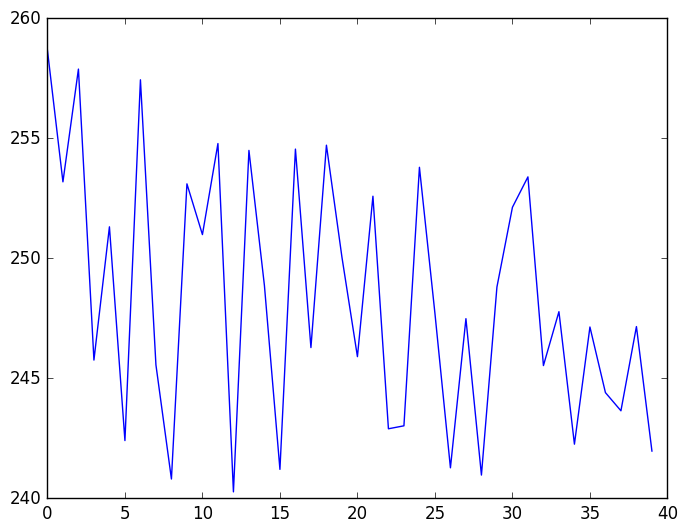

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0bee9dca50>

In [143]:
PyPlot.plot(rec_errors)

### Function to plot the weights

In [ ]:
# https://github.com/dfdx/Boltzmann.jl/blob/master/examples/mnistexample.jl

function plot_weights(W, imsize)
    padding=10
    h, w = imsize
    n = size(W, 1)
    rows = Int(floor(sqrt(n)))
    cols = Int(ceil(n / rows))
    halfpad = div(padding, 2)
    dat = zeros(rows * (h + padding), cols * (w + padding))
    for i=1:n
        wt = W[i, :]
        wim = reshape(wt, imsize)
        wim = wim ./ (maximum(wim) - minimum(wim))
        r = div(i - 1, cols) + 1
        c = rem(i - 1, cols) + 1
        dat[(r-1)*(h+padding)+halfpad+1 : r*(h+padding)-halfpad,
            (c-1)*(w+padding)+halfpad+1 : c*(w+padding)-halfpad] = wim
    end
    #ImageView.view(dat)
    return dat
end

In [ ]:
rbm = initialize_RBM(784, 50, 0.01, Float32)
M = generate_M(rbm.W,25);
PyPlot.imshow(M,"gray")

## Train model several epochs 

Plot the weights after training

In [ ]:
n_epochs = 100
batch_size = 200
K = 1
lr = 0.01

fit!(rbm, X_train,  batch_size,  n_epochs, K, lr, T, true)

In [ ]:
M = generate_M(rbm.W, 10);
PyPlot.imshow(M,"gray")

In [ ]:
PyPlot.imshow(M,"gray", vmin=minimum(M), vmax = maximum(M))

In [ ]:
dat = plot_weights(rbm.W[1:50,:], (28,28));
PyPlot.imshow(dat,"gray")

## Scaling individually the features of the plot: TO DO

#### Python code for printing the feature detectors


    for i, comp in enumerate(self.W.T):
        plt.subplot(15, 15, i + 1)
        if min_max_scale:
            plt.imshow(comp.reshape((28, 28)),
                       cmap= plt.get_cmap('gray'), vmin=min_, vmax=max_)

In [ ]:
function plot_per_hidden_unit(W, n_columns, minmax_scale)
    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns))   

    print("\ncostat: ", costat,
          "\nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    if minmax_scale == true
        min_ = minimum(W)
        max_ = maximum(W)
    end
                    
    for i in 1:n_hid
        comp = W[i,:]
        PyPlot.subplot(10, 10, i+1)
        if minmax_scale == true
            PyPlot.imshow(reshape(comp, 28, 28),
            cmap= PyPlot.get_cmap("gray"), vmin=min_, vmax=max_)
        end
    end
    
end

In [ ]:
plot_per_hidden_unit(rbm.W, rbm.n_hid, true)